scan line0: [3102 3265 3272 3258 3289 3388 3293 3379 3396 3404 3416 3437 3354 3455 3436
 3433 3517 3574 3482 3626 3530 3608 3529 3561 3585 3606 3573 3689 3622 3732
 3715 3756 3748 3791 3703 3801 3742 3735 3726 3758 3697 3760 3746 3734 3762
 3770 3769 3834 3743 3856 3925 3927 3851 3904 3971 3959 3977 4036 4042 4045
 4027 4066 4104 4338 4778 5440 6258 6913 7277 7851 7852 7865 7843 7869 7842
 7847 7825 7682 7490 6886 6348 5514 4874 4416 4045 4047 3945 3904 3831 3865
 3818 3770 3696 3757 3728 3713 3685 3635 3549 3635 3576 3543 3575 3599 3540
 3621 3567 3555 3554 3592 3557 3628 3507 3554 3480 3487 3458 3453 3394 3397
 3343 3342 3299 3271 3148 3167 3038   14]
scan line1: [3120 3243 3224 3332 3297 3359 3348 3464 3371 3440 3379 3477 3426 3466 3454
 3536 3476 3597 3561 3592 3575 3641 3588 3582 3624 3655 3621 3697 3676 3707
 3741 3758 3716 3823 3728 3783 3761 3755 3716 3783 3736 3770 3774 3766 3747
 3837 3808 3816 3820 3893 3909 3978 3905 3948 3999 4032 3959 4050 4079 4105
 4064 4081 4081 4340 4

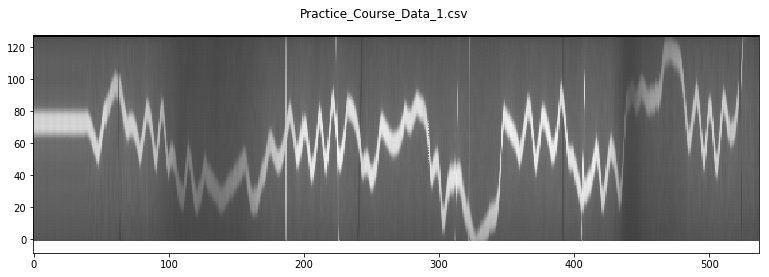

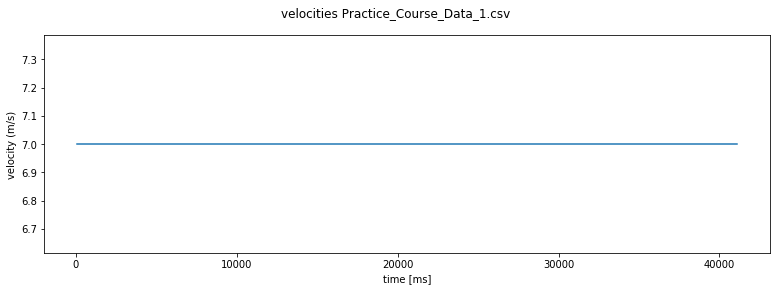

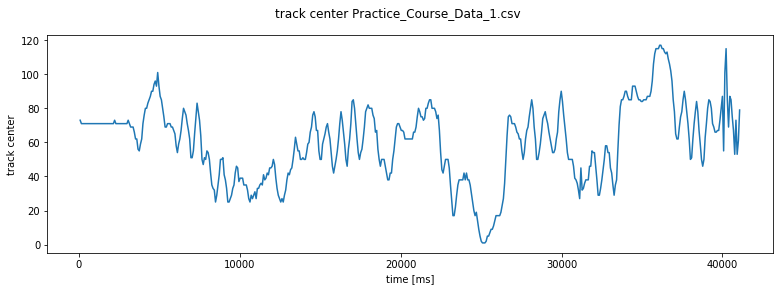

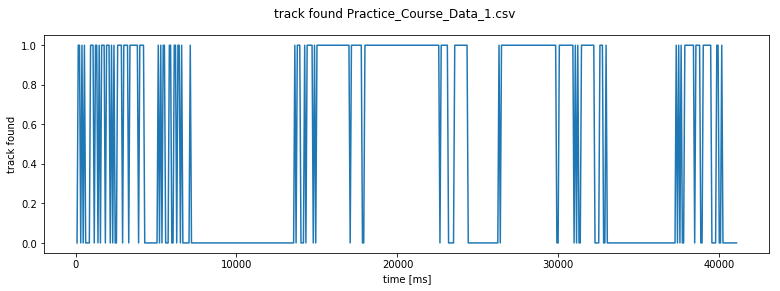

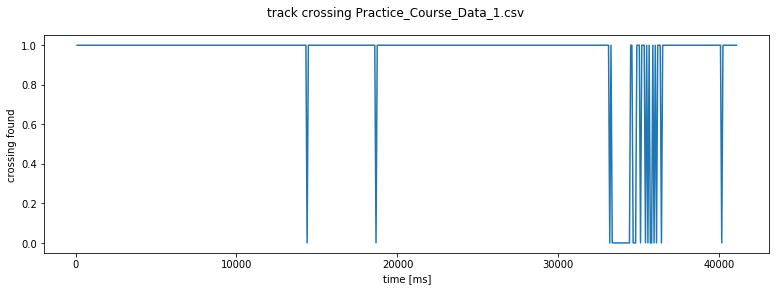

In [7]:

# coding: utf-8

# # EECS192 Spring 2017 Track Finding from 1D line sensor data

# In[6]:

# changed to use 8 bit compressed line sensor values
# data format: 128 comma separated values, last value in line has space, not comma
# line samples are about 10 ms apart
#  csv file format time in ms, 128 byte array, velocity
# note AGC has already been applied to data, and camera has been calibrated for illumination effects


# In[8]:

import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

# import scipy.ndimage as ndi  # useful for 1d filtering functions
plt.close("all")   # try to close all open figs

# In[9]:

# Graphing helper function
def setup_graph(title='', x_label='', y_label='', fig_size=None):
    fig = plt.figure()
    if fig_size != None:
        fig.set_size_inches(fig_size[0], fig_size[1])
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)


# Line scan plotting function.
# 

# In[10]:

def plot_frame(linearray):
    nframes = np.size(linearray)/128
    n = range(0,128)
    print 'number of frames', nframes
    print 'size of line', np.size(linearray[0,:])
    for i in range(0, nframes-1):
        setup_graph(title='$x[n]$', x_label='$n$', y_label='row'+str(i)+' $ xa[n]$', fig_size=(15,2))
        plt.subplot(1,3,1)
        _ = plt.plot(n,linearray[0,:])
        plt.subplot(1,3,2)
        _ = plt.plot(n,linearray[i,:])
    # plot simple difference between frame i and first frame
        plt.subplot(1,3,3)
        _ = plt.plot(n,linearray[i,:] - linearray[0,:])
        plt.ylabel('Frame n - Frame 0')


# ### grayscale plotting of line function:
# 

# In[11]:

CAMERA_LENGTH = 128
INTENSITY_MIN = 0
INTENSITY_MAX = 255
def plot_gray(fig, camera_data):
  # x fencepost positions of each data matrix element
  x_mesh = []
  for i in range(0, len(camera_data)+1):
    x_mesh.append([i-0.5] * (CAMERA_LENGTH + 1))
  x_mesh = np.array(x_mesh)
  
  # y fencepost positions of each data matrix element
  y_array = range(0, CAMERA_LENGTH + 1)
  y_array = list(map(lambda x: x - 0.5, y_array))
  y_mesh = np.array([y_array] * (len(camera_data)+1))
    
  data_mesh = np.array(camera_data)
  vmax1 = np.max(data_mesh)
  data_mesh = INTENSITY_MAX * data_mesh/vmax1  # normalize intensity
  
  fig.set_xlim([-0.5, len(camera_data) - 0.5])
  fig.set_ylim([-8.5, CAMERA_LENGTH - 0.5])

  fig.pcolorfast(x_mesh, y_mesh, data_mesh,
      cmap='gray', vmin=INTENSITY_MIN, vmax=INTENSITY_MAX,
      interpolation='None')


# In[12]:

### inputs:
# linescans - An array of length n where each element is an array of length 128. Represents n frames of linescan data.

### outputs:
# track_center_list - A length n array of integers from 0 to 127. Represents the predicted center of the line in each frame.
# track_found_list - A length n array of booleans. Represents whether or not each frame contains a detected line.
# cross_found_list - A length n array of booleans. Represents whether or not each frame contains a crossing.

def find_track(linescans):
    n = len(linescans)
    track_center_list = n * [64]
    track_found_list = n * [True]
    cross_found_list = n * [False]
    ### Code to be added here
    ###
    ###
    max_v = 0
    for i in range(0, n):
      frame = linescans[i]
      track_center_list[i] = np.argmax(frame)
      if (frame[track_center_list[i]] > max_v):
        max_v = frame[track_center_list[i]]
      max_i = track_center_list[i]
      mode = stats.mode(frame)[0][0]
      if (frame[max_i] - (frame[max_i] * 0.55)) < mode:
        track_found_list[i] = False
      if(max_v - (max_v * 0.685)) < mode:
        cross_found_list[i] = True

    
    return track_center_list, track_found_list, cross_found_list




################
# need to use some different tricks to read csv file
import csv
filename = 'Practice_Course_Data_1.csv'
#filename = 'natcar2016_team1_short.csv'
csvfile=open(filename, 'rU')
telemreader=csv.reader(csvfile, delimiter=',', quotechar='"')
# Actual Spring 2016 Natcar track recording by Team 1.
telemreader.next() # discard first line
telemdata = telemreader.next() # format time in ms, 128 byte array, velocity
linescans=[]  # linescan array
times=[]
velocities=[]
for row in telemreader:
    times.append(eval(row[0])) # sample time
    velocities.append(eval(row[2])) # measured velocity
    line = row[1] # get scan data
    arrayline=np.array(eval(line)) # convert line to an np array
    linescans.append(arrayline)
print 'scan line0:', linescans[0]
print 'scan line1:', linescans[1]

track_center_list, track_found_list, cross_found_list = find_track(linescans)
# for i, (track_center, track_found, cross_found) in enumerate(zip(track_center_list, track_found_list, cross_found_list)):
#    print 'scan # %d center at %d. Track_found = %s, Cross_found = %s' %(i,track_center,track_found, cross_found)


############# plots ###########
#fig=plt.figure()
fig = plt.figure(figsize = (16, 3))
fig.set_size_inches(13, 4)
fig.suptitle("%s\n" % (filename))     
ax = plt.subplot(1, 1, 1)
#plot_gray(ax, linescans[0:1000])  # plot smaller range if hard too see
plot_gray(ax, linescans) 


############# plot of velocities
fig = plt.figure(figsize = (8, 4))
fig.set_size_inches(13, 4)
fig.suptitle("velocities %s\n" % (filename))   
plt.xlabel('time [ms]')
plt.ylabel('velocity (m/s)')  
plt.plot(times,velocities)

###############plot of found track position 

fig = plt.figure(figsize = (8, 4))
fig.set_size_inches(13, 4)
fig.suptitle("track center %s\n" % (filename))   
plt.xlabel('time [ms]')
plt.ylabel('track center')  
plt.plot(times,track_center_list)

###############plot of track found

fig = plt.figure(figsize = (8, 4))
fig.set_size_inches(13, 4)
fig.suptitle("track found %s\n" % (filename))   
plt.xlabel('time [ms]')
plt.ylabel('track found')  
plt.plot(times,track_found_list)

###############plot of crossing found

fig = plt.figure(figsize = (8, 4))
fig.set_size_inches(13, 4)
fig.suptitle("track crossing %s\n" % (filename))   
plt.xlabel('time [ms]')
plt.ylabel('crossing found')  
plt.plot(times,cross_found_list)